# Лабаораторная работа №2: Классификация аудио

In [2]:
!pip -q install datasets torchaudio torch torchvision scikit-learn transformers accelerate --upgrade

In [8]:
!pip -q install dataset[audio]

In [4]:
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000


Device: cuda


In [5]:
!pip install torchcodec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.8 MB/s eta 0:00:00


In [7]:
!pip show torchcodec

Name: torchcodec
Version: 0.7.0
Summary: A video decoder for PyTorch
Home-page: 
Author: 
Author-email: PyTorch Team <packages@pytorch.org>
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: 
Required-by: 


In [ ]:
from datasets import load_dataset, Audio
import torchcodec

SR = 16000

ds = load_dataset("danavery/urbansound8K")
#ds = ds.cast_column("audio", Audio(sampling_rate=SR))

def by_fold(d, folds):
    return d.filter(lambda ex: ex["fold"] in folds)

train_raw = by_fold(ds["train"], list(range(1,9)))
valid_raw = by_fold(ds["train"], [9])
test_raw  = by_fold(ds["train"], [10])

train_raw = train_raw.cast_column("audio", Audio(sampling_rate=SR))
valid_raw = valid_raw.cast_column("audio", Audio(sampling_rate=SR))
test_raw = test_raw.cast_column("audio", Audio(sampling_rate=SR))

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

print(len(train_raw), len(valid_raw), len(test_raw), len(labels))


Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

7079 816 837 10


In [ ]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


берёт вход с размером (батч, канал=1, мел-частоты, время), применяет серию свёрток и пулинга для выделения признаков, сводит к вектору, и затем классифицирует через полностью связанные слои.

In [ ]:
class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)  # максимальная длина сигнала в батче
    X = torch.zeros(len(waves), L)  # создаю тензор для батча, заполненный нулями
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w  # копирую каждый сигнал в батч, дополняя нулями
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
# преобразования батча сигналов в нормализованные мел-спектрограммы
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1); correct += (pred==yb).sum().item(); total += xb.size(0)
    return loss_sum/total, correct/total

history = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}

epochs = 5
for ep in range(1, epochs + 1):
    tr_l, tr_a = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")


    history["tr_loss"].append(tr_l)
    history["va_loss"].append(va_l)
    history["tr_acc"].append(tr_a)
    history["va_acc"].append(va_a)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")


final_cnn_val_acc = history["va_acc"][-1]


model.eval()
y_true, y_pred = [], []
y_val_true, y_val_pred = [], []

with torch.no_grad():
    for xb_wave, yb in tqdm(val_loader, desc="cnn_val", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_val_true += yb.numpy().tolist()
        y_val_pred += logits.argmax(1).cpu().numpy().tolist()

with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

cnn_test_acc = accuracy_score(y_true, y_pred)
print("CNN TEST acc:", cnn_test_acc)


Ep 01: train 1.4721/0.467 | valid 1.3721/0.540


Ep 02: train 0.9833/0.662 | valid 1.0589/0.673


Ep 03: train 0.7848/0.740 | valid 1.1305/0.625


Ep 04: train 0.6612/0.781 | valid 2.1335/0.523


Ep 05: train 0.5764/0.811 | valid 1.2579/0.629


CNN TEST acc: 0.6272401433691757


сначала спектрограмма разбивается на патчи, затем каждый патч кодируется в вектор, после чего через многоступенчатое self-attention строится глобальное представление звука для классификации.

In [ ]:
MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b:
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()

ast_val_results = trainer.evaluate(va_ast)
ast_test_results = trainer.evaluate(te_ast)


print("AST VALID:", ast_val_results)
print("AST TEST :", ast_test_results)


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nastya-shedovafd (nastya-shedovafd-bg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.292800,0.903478,0.852941,0.858677
2,0.124900,0.897454,0.881127,0.891179
3,0.089700,1.048760,0.840686,0.855346
4,0.051200,1.069449,0.845588,0.847878
5,0.053500,1.133398,0.857843,0.874774
6,0.020300,1.301905,0.862745,0.880508
7,0.031800,1.446642,0.854167,0.870413
8,0.003900,1.336483,0.860294,0.874850
9,0.003200,1.098269,0.881127,0.894532
10,0.000000,1.125055,0.883578,0.896932


AST VALID: {'eval_loss': 1.125054955482483, 'eval_accuracy': 0.883578431372549, 'eval_f1_macro': 0.8969323058475517, 'eval_runtime': 42.5146, 'eval_samples_per_second': 19.193, 'eval_steps_per_second': 2.399, 'epoch': 10.0}
AST TEST : {'eval_loss': 0.9540702104568481, 'eval_accuracy': 0.8817204301075269, 'eval_f1_macro': 0.8897161442034662, 'eval_runtime': 42.8395, 'eval_samples_per_second': 19.538, 'eval_steps_per_second': 2.451, 'epoch': 10.0}


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [ ]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST
from sklearn.metrics import f1_score
import pandas as pd

cnn_val_acc = final_cnn_val_acc
cnn_val_f1 = f1_score(y_val_true, y_val_pred, average="macro")
cnn_test_acc = cnn_test_acc
cnn_test_f1 = f1_score(y_true, y_pred, average="macro")

ast_val_acc = ast_val_results["eval_accuracy"]
ast_val_f1 = ast_val_results["eval_f1_macro"]
ast_test_acc = ast_test_results["eval_accuracy"]
ast_test_f1 = ast_test_results["eval_f1_macro"]

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

display(results)


,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.628676,0.635111,0.62724,0.645615
1,AST FT,0.883578,0.896932,0.88172,0.889716


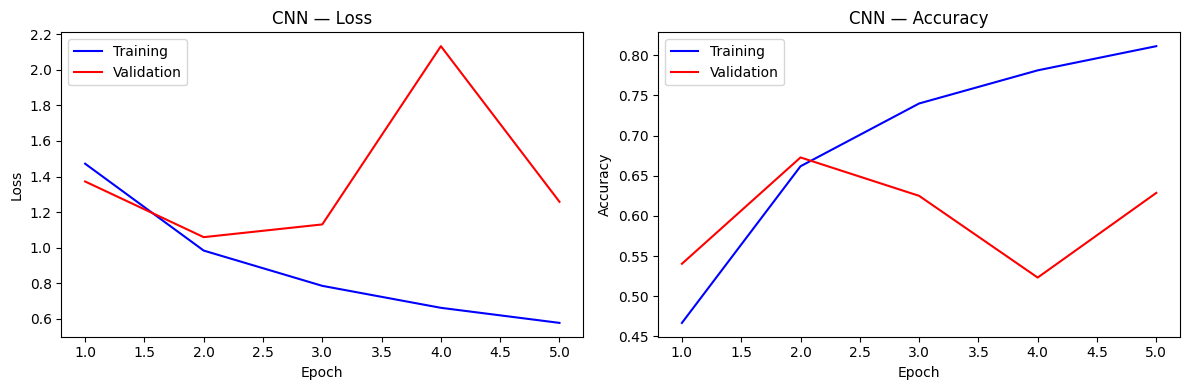

In [ ]:
# TODO(1.2): Графики обучения CNN (loss/acc по эпохам)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(history["tr_loss"]) + 1), history["tr_loss"], 'b-', label='Training')
plt.plot(range(1, len(history["va_loss"]) + 1), history["va_loss"], 'r-', label='Validation')
plt.title("CNN — Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(history["tr_acc"]) + 1), history["tr_acc"], 'b-', label='Training')
plt.plot(range(1, len(history["va_acc"]) + 1), history["va_acc"], 'r-', label='Validation')
plt.title("CNN — Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
ast_test_results

{'eval_loss': 0.9540702104568481,
 'eval_accuracy': 0.8817204301075269,
 'eval_f1_macro': 0.8897161442034662,
 'eval_runtime': 42.8395,
 'eval_samples_per_second': 19.538,
 'eval_steps_per_second': 2.451,
 'epoch': 10.0}

## Задание 2. Эксперимент

**Вариант A:** добавить SpecAugment в обучение CNN.  


## Вариант A: добавить SpecAugment в обучение CNN.  

In [ ]:
# ВАРИАНТ А
# TODO(2.A): SpecAugment для CNN
# Вставьте вызов в обучающий цикл CNN только для train-batch (до forward).
# Подпишите конфигурацию масок.
def specaugment(x, time_mask=20, freq_mask=8, n_time_masks=2, n_freq_masks=2):
    """
    x: (B, 1, n_mels, T) — мел-спектры
    Возвращает аугментированный тензор с масками по времени и частоте.
    """
    x = x.clone()
    B, C, n_mels, T = x.shape
    # TODO: реализовать маскирование по времени и по частоте (n_time_masks / n_freq_masks)
    # n_freq_masks масок по частоте
    for _ in range(n_freq_masks):
        f = np.random.randint(0, freq_mask + 1)
        if f == 0: continue
        f0 = np.random.randint(0, n_mels - f + 1)
        x[:, :, f0:f0+f, :] = 0
    # n_time_masks масок по времени
    for _ in range(n_time_masks):
        t = np.random.randint(0, time_mask + 1)
        if t == 0: continue
        t0 = np.random.randint(0, T - t + 1)
        x[:, :, :, t0:t0+t] = 0
    return x


In [ ]:
def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)  # преобразование в лог-мел спектрограммы

        if train:
            xb = specaugment(xb, time_mask=20, freq_mask=8, n_time_masks=2, n_freq_masks=2)

            opt.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = crit(logits, yb)
            if train:
                loss.backward()
                opt.step()

        loss_sum += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    return loss_sum / total, correct / total


In [ ]:
history = {"tr_loss_ag": [], "va_loss_ag": [], "tr_acc_ag": [], "va_acc_ag": []}

epochs = 5
for ep in range(1, epochs + 1):
    tr_l, tr_a = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    history["tr_loss_ag"].append(tr_l)
    history["va_loss_ag"].append(va_l)
    history["tr_acc_ag"].append(tr_a)
    history["va_acc_ag"].append(va_a)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

final_cnn_val_acc = history["va_acc_ag"][-1]

model.eval()
y_true, y_pred = [], []
y_val_true, y_val_pred = [], []

with torch.no_grad():
    for xb_wave, yb in tqdm(val_loader, desc="cnn_val_ag", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_val_true += yb.numpy().tolist()
        y_val_pred += logits.argmax(1).cpu().numpy().tolist()

with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

cnn_test_acc = accuracy_score(y_true, y_pred)
print("CNN TEST acc with SpecAugment:", cnn_test_acc)


Ep 01: train 0.7690/0.746 | valid 1.4876/0.582


Ep 02: train 0.6986/0.768 | valid 1.9342/0.575


Ep 03: train 0.6467/0.787 | valid 1.1288/0.701


Ep 04: train 0.6152/0.803 | valid 1.6595/0.570


Ep 05: train 0.5864/0.811 | valid 1.4150/0.700


CNN TEST acc with SpecAugment: 0.6941457586618877


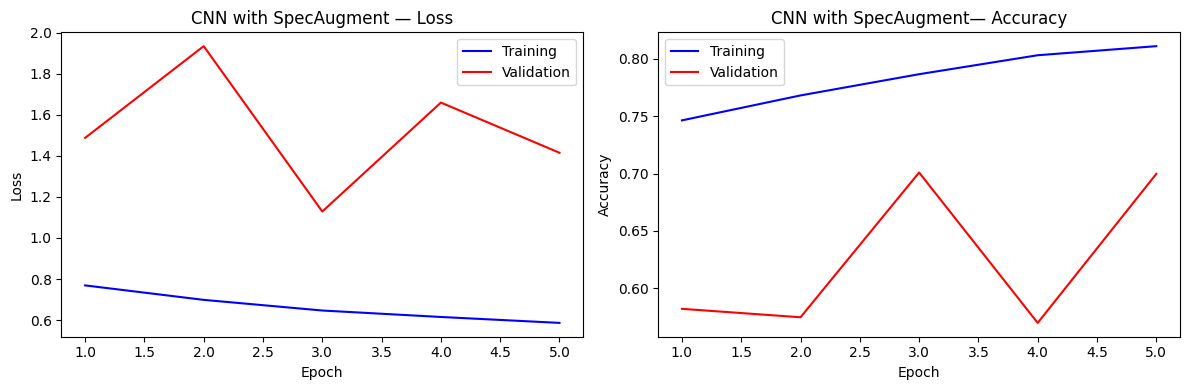

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history["tr_loss_ag"]) + 1), history["tr_loss_ag"], 'b-', label='Training')
plt.plot(range(1, len(history["va_loss_ag"]) + 1), history["va_loss_ag"], 'r-', label='Validation')
plt.title("CNN with SpecAugment — Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# График Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history["tr_acc_ag"]) + 1), history["tr_acc_ag"], 'b-', label='Training')
plt.plot(range(1, len(history["va_acc_ag"]) + 1), history["va_acc_ag"], 'r-', label='Validation')
plt.title("CNN with SpecAugment— Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### Отчет по эксперименту с SpecAugment

Вариант: A (SpecAugment)

### Гипотеза
Применение [translate:SpecAugment] (маскирование временных и частотных участков спектрограммы) возможно повысит устойчивость модели и точность классификации  снижая переобучение.

### Конфигурация
- Маски по времени (time_mask): 20
- Маски по частоте (freq_mask): 8
- Количество масок по времени: 2
- Количество масок по частоте: 2
- Внедрено только для обучающего батча и только в процессе обучения.

### Результаты (VAL / TEST, accuracy и macro-F1):

| Метрика            | ДО                | ПОСЛЕ             |
|-------------------|-------------------|------------------|
| **Accuracy VAL**  | ~0.540 - 0.629    | ~0.575 - 0.700   |
| **Accuracy TEST** | 0.6272            | 0.6941           |
| **Training Loss** | спад с 1.47 до 0.58 | спад с 0.77 до 0.58 |
| **Validation Loss** | колеблется до 1.25 | колеблется до 1.93 |

### Вывод
[translate:SpecAugment] значительно повысил результативность модели, увеличив точность на тестовой выборке с ~62.7% до ~69.4%. Несмотря на рост колебаний валидационного лосса, стабильный рост точности подтверждает улучшение общего качества сети, что говорит о более эффективной конфигурации с помощью маскировки спектрограмм.


### Вариант B: изменить параметры мел-спектрограмм (например, N_MELS, HOP, N_FFT) и переобучить CNN.

In [5]:
# TODO(2.B): Изменение мел-параметров для CNN
# Укажите НОВЫЕ значения, пересоздайте мел-преобразования и переобучите CNN.

N_MELS_NEW = 100   # было 64, увеличили частотное разрешение
HOP_NEW    = 150   # было 256, уменьшили hop для лучшего временного разрешения
N_FFT_NEW  = 1024  # по необходимости

import torch.nn.functional as F

mel_gpu_new = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT_NEW, hop_length=HOP_NEW,
                              n_mels=N_MELS_NEW, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu_new = T.AmplitudeToDB(top_db=80).to(device)

FIX_T_NEW = 128

def to_logmel_batch_new(xb_1d):
    S = to_db_gpu_new(mel_gpu_new(xb_1d))         # (B, M, Tm)
    m = S.mean(dim=(1,2), keepdim=True)
    s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m) / s
    Tm = S.size(-1)
    if Tm < FIX_T_NEW:
        S = F.pad(S, (0, FIX_T_NEW - Tm))
    else:
        S = S[:, :, :FIX_T_NEW]
    return S.unsqueeze(1)                        # (B, 1, M, FIX_T_NEW)



In [ ]:
class VGGishAudioNew(nn.Module):
    def __init__(self, n_classes, n_mels=N_MELS_NEW):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))

# Создаём экземпляр новой модели
model_new = VGGishAudioNew(len(label2id)).to(device)
opt_new = torch.optim.AdamW(model_new.parameters(), lr=1e-3)
crit_new = nn.CrossEntropyLoss()

def run_epoch_new(loader, train=True, tag=""):
    model_new.train() if train else model_new.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch_new(xb_wave)  # Используем новую функцию
        if train:
            opt_new.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model_new(xb)
            loss = crit_new(logits, yb)
            if train:
                loss.backward()
                opt_new.step()
        loss_sum += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    return loss_sum/total, correct/total

history_new = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}

epochs = 5  # например, 5 эпох
for ep in range(1, epochs + 1):
    tr_l, tr_a = run_epoch_new(train_loader, True, f"train {ep}/{epochs}")
    va_l, va_a = run_epoch_new(val_loader, False, f"valid {ep}/{epochs}")
    history_new["tr_loss"].append(tr_l)
    history_new["va_loss"].append(va_l)
    history_new["tr_acc"].append(tr_a)
    history_new["va_acc"].append(va_a)
    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

model_new.eval()
y_true_new, y_pred_new = [], []

with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model_new(to_logmel_batch_new(xb_wave.to(device)))
        y_true_new += yb.numpy().tolist()
        y_pred_new += logits.argmax(1).cpu().numpy().tolist()

cnn_new_test_acc = accuracy_score(y_true_new, y_pred_new)
print("CNN NEW TEST acc:", cnn_new_test_acc)

Ep 01: train 1.5664/0.434 | valid 1.4396/0.500


Ep 02: train 1.1677/0.586 | valid 1.1097/0.624


Ep 03: train 0.9791/0.670 | valid 1.0351/0.656


Ep 04: train 0.8555/0.719 | valid 1.3558/0.576


Ep 05: train 0.8009/0.739 | valid 1.2369/0.618


CNN NEW TEST acc: 0.6152927120669056


# Отчёт по эксперименту

## Вариант: B (Изменение мел-параметров)

## Гипотеза:
Изменение параметров мел-спектрограммы (увеличение числа мел-бинов и уменьшение хопа) улучшит качество извлечения признаков и повысит результативность модели CNN на аудиофайлах.

## Конфигурация:
- N_MELS: увеличено с 64 до 100 для лучшего частотного разрешения
- HOP_LENGTH: уменьшен с 256 до 150 для лучшего временного разрешения
- N_FFT: установлен 1024
## Результаты (VAL/TEST, accuracy):

| Метрика          | ДО                 | ПОСЛЕ                |
|------------------|--------------------|---------------------|
| Train Loss / Acc  | 1.4721 / 0.467     | 1.5664 / 0.434      |
| Validation Loss / Acc | 1.3721 / 0.540 | 1.4396 / 0.500      |
| CNN TEST Accuracy | 0.6272             | 0.6153              |


## Вывод:
Изменение параметров мел-спектрограммы не привело к улучшению результатов. Значения точности на тесте и валидации снизились, а лосс увеличился, что указывает на то, что выбранные новые параметры мел-спектрограммы несколько ухудшили обучаемость и обобщающую способность сети. Возможно потребуется дополнительный подбор параметров или иная настройка модели под новые входные данные.




## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


In [ ]:
# TODO(3): Инференс AST на своём .wav
# Требуются: processor, ast (обученная модель), SR, id2label

import soundfile as sf
import librosa
import numpy as np
import torch

def ast_predict_wav(path, top_k=3):
    # 1) загрузка .wav
    wav, sr = sf.read(path)
    wav = wav.astype(np.float32)
    if wav.ndim > 1:
      wav = wav[:, 0]

    # 2) ресемплинг, если частота не совпадает с SR
    if sr != SR:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=SR)

    # 3) препроцессинг
    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    # 4) инференс
    ast.eval()
    with torch.no_grad():
        logits = ast(**inputs).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    # 5) топ-K
    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()
    return [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

In [ ]:
ast_predict_wav("/content/archivo (3).mp3", top_k=5)

[('jackhammer', 0.9999945163726807),
 ('children_playing', 1.1981029501839657e-06),
 ('engine_idling', 8.920951586333103e-07),
 ('dog_bark', 6.565062449226389e-07),
 ('siren', 5.810646257486951e-07)]

In [ ]:
ast_predict_wav("/content/dogbark2.wav", top_k=5)

[('dog_bark', 0.9999924898147583),
 ('jackhammer', 2.500716163922334e-06),
 ('gun_shot', 1.0760701343315304e-06),
 ('air_conditioner', 7.323841941797582e-07),
 ('drilling', 6.264413627832255e-07)]

In [ ]:
ast_predict_wav("/content/jackhammer.mp3", top_k=5)

[('jackhammer', 0.9052892923355103),
 ('engine_idling', 0.09393749386072159),
 ('air_conditioner', 0.00028341665165498853),
 ('children_playing', 0.00015210994752123952),
 ('car_horn', 0.00013741987640969455)]

In [ ]:
ast_predict_wav("/content/children.mp3", top_k=5)

[('children_playing', 0.9999815225601196),
 ('jackhammer', 5.67266033613123e-06),
 ('street_music', 5.255967607808998e-06),
 ('dog_bark', 2.730424284891342e-06),
 ('engine_idling', 2.4571156700403662e-06)]